## Summary
In this notebook, the paired data from the Cyanobacteria dataset is analysed for the NPClassScore paper. This data originates from MSV000084950.

The newly developed implementation of NPClassScore is used in combination with Metcalf scoring to discover BGC-MS/MS spectrum links in the Cyanobacteria dataset. Validated links from the PoDP are used to validate the results.

Sections:
- Loading the MSV000084950 dataset
- Scoring using the new NPClassScore method
- Investigating NPClassScore cutoff
- Counting number of links
- Making plots showing the filtered links
- Investigate known links

## Loading MSV000084950 dataset

In [2]:
import sys, csv, os
# if running from clone of the git repo
sys.path.append('../../src')

# import the main NPLinker class. normally this all that's required to work
# with NPLinker in a notebook environment
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nplinker.nplinker import NPLinker
from nplinker.metabolomics import Spectrum
from collections import Counter, defaultdict

In [4]:
# load local crusemann data
npl = NPLinker(
    {'dataset':
     {'root': '/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/'},
    'docker':
     {'run_canopus': True}})
npl.load_data()

14:47:38 [INFO] config.py:164, Loading from local data in directory /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/
14:47:38 [WARNING] loader.py:52, WARNING: unable to find extra_nodes_file in path "/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/quantification_table_reformatted/*.csv"
14:47:38 [WARNING] loader.py:52, WARNING: unable to find metadata_table_file in path "/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/metadata_table/metadata_table*.txt"
14:47:38 [WARNING] loader.py:52, WARNING: unable to find quantification_table_file in path "/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/quantification_table/quantification_table*.csv"
14:47:38 [INFO] loader.py:94, Trying to discover correct bigscape directory under /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/bigscape
14:47:38 [INFO] loader.py:98, Found network files directory: /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/bigscape/network

/home/hechth/dev/git/hechth/nplinker/src/nplinker/class_info/class_matches.py:248: FutureWarning: In a future version, passing float-dtype values containing NaN and an integer dtype will raise IntCastingNaNError (subclass of ValueError) instead of silently ignoring the passed dtype. To retain the old behavior, call Series(arr) or DataFrame(arr) without passing a dtype.
  counts_df = pd.DataFrame.from_dict(counts, dtype=int)


14:47:47 [INFO] class_matches.py:44, Loaded MIBiG classes, and class matching tables
14:47:47 [INFO] loader.py:777, Found CANOPUS dir, CANOPUS not run again!
14:47:47 [INFO] chem_classes.py:199, reading canopus results for spectra from /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/canopus/cluster_index_classifications.txt
14:47:47 [INFO] chem_classes.py:544, reading molnetenhancer results from /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/molnetenhancer
14:47:47 [INFO] loader.py:448, Writing common strain labels to /home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/common_strains.csv
14:47:47 [INFO] loader.py:461, Strains filtered down to total of 23
14:47:47 [INFO] loader.py:370, No further strain filtering to apply


True

In [5]:
# Basic functionality
# ===================
#
# Once you have an NPLinker object with all data loaded, there are a collection of simple
# methods and properties you can use to access objects and metadata. Some examples are 
# given below, see https://nplinker.readthedocs.io/en/latest/ for a complete API description.

# configuration/dataset metadata
# - a copy of the configuration as parsed from the .toml file (dict)
print(npl.config) 
# - the path to the directory where various nplinker data files are located (e.g. the 
#   default configuration file template) (str)
print(npl.data_dir)
# - a dataset ID, derived from the path for local datasets or the paired platform ID
#   for datasets loaded from that source (str)
print(npl.dataset_id)
# - the root directory for the current dataset (str)
print(npl.root_dir)

# objects
# - you can directly access lists of each of the 4 object types:
print('BGCs:', len(npl.bgcs))
print('GCFs:', len(npl.gcfs)) # contains GCF objects
spectra_in_dataset = [spec for spec in npl.spectra if 'strains=0' not in str(spec)]
print('Spectra:', len(npl.spectra), # contains Spectrum objects
      '({} spectra actually present in currently selected strains in strain_mappings.csv)'.format(len(spectra_in_dataset)))
print('Molecular Families:', len(npl.molfams)) # contains MolecularFamily objects

{'loglevel': 'INFO', 'logfile': '', 'log_to_stdout': True, 'repro_file': '', 'dataset': {'root': '/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/', 'overrides': {}, 'platform_id': ''}, 'antismash': {'antismash_format': 'default', 'ignore_spaces': False}, 'docker': {'run_bigscape': True, 'run_canopus': True, 'extra_canopus_parameters': '--maxmz 600 formula zodiac structure canopus'}, 'webapp': {'tables_metcalf_threshold': 2.0}, 'scoring': {'rosetta': {}}}
/home/hechth/dev/git/hechth/nplinker/src/nplinker/data

/home/hechth/nplinker_data/cyanobacteria_complete_MSV000084950/
BGCs: 301
GCFs: 184
Spectra: 729 (707 spectra actually present in currently selected strains in strain_mappings.csv)
Molecular Families: 341


In [6]:
# Count spectra with chemical class info
spectra_in_dataset_with_class = []
spectra_in_dataset_no_class = []
for spec in spectra_in_dataset:
    spec_can = npl.chem_classes.canopus.spectra_classes.get(str(spec.spectrum_id))
    if not spec_can:
        spec_mne = npl.chem_classes.molnetenhancer.spectra_classes(str(spec.spectrum_id))
        if not spec_mne:
            spectra_in_dataset_no_class.append(spec)
        else:
            spectra_in_dataset_with_class.append(spec)
    else:
        spectra_in_dataset_with_class.append(spec)
print(f"From the {len(spectra_in_dataset)} spectra present in current strains, {len(spectra_in_dataset_with_class)} spectra have class info")

From the 707 spectra present in current strains, 673 spectra have class info


## Scoring using the new NPClassScore method
Use the scoring methods in NPLinker to find links with:
- Metcalf scoring
- Metcalf + NPClassScore scoring

In [7]:
mc = npl.scoring_method('metcalf')

# Now mc is an instance of the class that implements Metcalf scoring. Once
# you have such an instance, you may change any of the parameters it exposes.
# In the case of Metcalf scoring, the following parameters are currently exposed:
# - cutoff (float): the scoring threshold. Links with scores less than this are excluded
# - standardised (bool): set to True to use standardised scores (default), False for regular
mc.cutoff = 2.5
mc.standardised = True

results = npl.get_links(npl.gcfs, mc, and_mode=True)

# get_links returns an instance of a class called LinkCollection. This provides a wrapper
# around the results of the scoring operation and has various useful properties/methods:
#
# - len(results) or .source_count will tell you how many of the input_objects were found to have links
print('Number of results: {}'.format(len(results)))
# - .sources is a list of those objects
objects_with_links = results.sources
# - .links is a dict with structure {input_object: {linked_object: ObjectLink}} 
objects_and_link_info = results.links
# - .get_all_targets() will return a flat list of *all* the linked objects (for all sources)
all_targets = results.get_all_targets() 
# - .methods is a list of the scoring methods passed to get_links
methods = results.methods

14:48:00 [INFO] methods.py:263, MetcalfScoring.setup (bgcs=301, gcfs=184, spectra=729, molfams=341, strains=23)
14:48:00 [INFO] methods.py:302, MetcalfScoring.setup preprocessing dataset (this may take some time)
14:48:01 [INFO] methods.py:320, MetcalfScoring.setup completed
Number of results: 184


In [8]:
# Initialise NPClassScore scoring the same way
# default method: 'mix' meaning use both CANOPUS and MolNetEnhancer with priority to CANOPUS
npcl = npl.scoring_method('npclassscore')
npcl.cutoff = 0.25

# Now only links are kept that pass the cutoff for both methods
results_both = npl.get_links(npl.gcfs, [mc, npcl], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_both)))
print(results_both.methods)

14:48:10 [INFO] np_class_scoring.py:296, Set up NPClassScore scoring
14:48:10 [INFO] np_class_scoring.py:298, Please choose one of the methods from ['mix', 'main', 'canopus', 'molnetenhancer']
14:48:10 [INFO] np_class_scoring.py:304, Currently the method 'mix' is selected
14:48:10 [INFO] np_class_scoring.py:310, Running NPClassScore...
14:48:10 [INFO] np_class_scoring.py:327, Using Metcalf scoring to get shared strains
14:48:11 [INFO] np_class_scoring.py:336, Calculating NPClassScore for 184 objects to 729 targets (36852 pairwise interactions that share at least 1 strain). This might take a while.
14:48:16 [WARNING] np_class_scoring.py:379, 38 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
14:48:16 [INFO] np_class_scoring.py:385, NPClassScore completed in 5.7s
Number of results for Metcalf and NPClassScore scoring: 183
{<nplinker.scoring.np_class_scoring.NPClassScoring object at 0x7f89cb639fa0>,

In [9]:
# Also create an object with both Metcalf and NPClassScore with a cutoff of 0 to investigate proper cutoff
npcl_0 = npl.scoring_method('npclassscore')
npcl_0.cutoff = 0

# Now only links are kept that pass the cutoff for both methods
results_0 = npl.get_links(npl.gcfs, [mc, npcl_0], and_mode=True)

print('Number of results for Metcalf and NPClassScore scoring: {}'.format(len(results_0)))
print(results_0.methods)

14:48:20 [INFO] np_class_scoring.py:310, Running NPClassScore...
14:48:20 [INFO] np_class_scoring.py:327, Using Metcalf scoring to get shared strains
14:48:20 [INFO] np_class_scoring.py:336, Calculating NPClassScore for 184 objects to 729 targets (36852 pairwise interactions that share at least 1 strain). This might take a while.
14:48:24 [WARNING] np_class_scoring.py:379, 38 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
14:48:24 [INFO] np_class_scoring.py:385, NPClassScore completed in 3.9s
Number of results for Metcalf and NPClassScore scoring: 184
{<nplinker.scoring.np_class_scoring.NPClassScoring object at 0x7f898f6acdc0>, <nplinker.scoring.methods.MetcalfScoring object at 0x7f89e8113f40>}


In [10]:
# score just with NPClassScore to check if missing known links have good scores

npcl_only = npl.scoring_method('npclassscore')
npcl_only.cutoff = 0

results_npcl = npl.get_links(npl.gcfs, [npcl_only], and_mode=True)

print('Number of results for NPClassScore scoring: {}'.format(len(results_npcl)))
print(results_npcl.methods)

14:48:27 [INFO] np_class_scoring.py:310, Running NPClassScore...
14:48:27 [INFO] np_class_scoring.py:327, Using Metcalf scoring to get shared strains
14:48:28 [INFO] np_class_scoring.py:336, Calculating NPClassScore for 184 objects to 729 targets (36852 pairwise interactions that share at least 1 strain). This might take a while.
14:48:32 [WARNING] np_class_scoring.py:379, 38 targets have no NPClassScore prediction due to missing class predictions and are kept by default. Adjust .filter_missing_scores to change.
14:48:32 [INFO] np_class_scoring.py:385, NPClassScore completed in 4.5s
Number of results for NPClassScore scoring: 184
{<nplinker.scoring.np_class_scoring.NPClassScoring object at 0x7f898eea3220>}


## Investigating NPClassScore cutoff
We choose 0.25 as a cutoff as around this value there is a marked drop in the number of links per GCF.

In [11]:
# gradient of class linking score cutoff

cs_cutoffs = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875]
d_all_num_links = []
d_all_num_filtered_links = {cut: [] for cut in cs_cutoffs}
d_all_no_scores = []
count_nones = False

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    
    # loop through cutoffs
    for cs_cut in cs_cutoffs:
        num_filtered_links = 0
        if gcf in results_0.links:
            # calculate number of links with npcl filtering
            filtered_links = []
            for link_data in results_0.get_sorted_links(mc, gcf):
                if isinstance(link_data.target, Spectrum):
                    npcl_score = npcl_0.format_data(link_data[npcl_0])
                    if npcl_score:
                        if float(npcl_score) > cs_cut:
                            filtered_links.append(link_data)
                    else:
                        if count_nones:
                            filtered_links.append(link_data)
            num_filtered_links = len(filtered_links)
        d_all_num_filtered_links[cs_cut].append(num_filtered_links)
    d_all_num_links.append(num_links)

In [12]:
print(f"NPClassScore_cutoff\tNumber_of_links\tChange")
print(f"0\t{np.mean(d_all_num_links):.2f}")
for cs_cut, filt_links in d_all_num_filtered_links.items():
    print(f"{cs_cut}\t{np.mean(filt_links):.2f}\t{(np.mean(filt_links)-np.mean(d_all_num_links))/np.mean(d_all_num_links):.2f}")

NPClassScore_cutoff	Number_of_links	Change
0	26.98
0.125	15.81	-0.41
0.25	12.61	-0.53
0.375	11.78	-0.56
0.5	9.88	-0.63
0.625	8.42	-0.69
0.75	6.20	-0.77
0.875	3.82	-0.86


## Counting number of links
For each GCF count the number of links with and without NPClassScore filtering using the chosen cutoff of 0.25.

In [13]:
# loop through all gcfs (objects) and count how many links exist (spectra)
all_num_links = []
all_num_filtered_links = []
all_no_scores = []
count_nones = False  # this controls if you want to include spectra without class info like npcl.filter_missing_scores

for gcf in npl.gcfs:
    # filter out MF links
    num_links = 0
    if gcf in results.links:
        num_links = len([link_data for link_data in results.get_sorted_links(mc, gcf)
                         if isinstance(link_data.target, Spectrum)])
    num_filtered_links = 0
    if gcf in results_both.links:
        if count_nones:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum)])
        else:
            num_filtered_links = len([link_data for link_data in results_both.get_sorted_links(mc, gcf)
                                      if isinstance(link_data.target, Spectrum) if link_data[npcl]])
    all_num_links.append(num_links)
    all_num_filtered_links.append(num_filtered_links)

np.mean(all_num_links), np.mean(all_num_filtered_links)

(26.97826086956522, 12.608695652173912)

In [14]:
# change in average links per GCF
(np.mean(all_num_filtered_links)-np.mean(all_num_links))/np.mean(all_num_links)

-0.532634971796938

## Making plots showing the filtered links

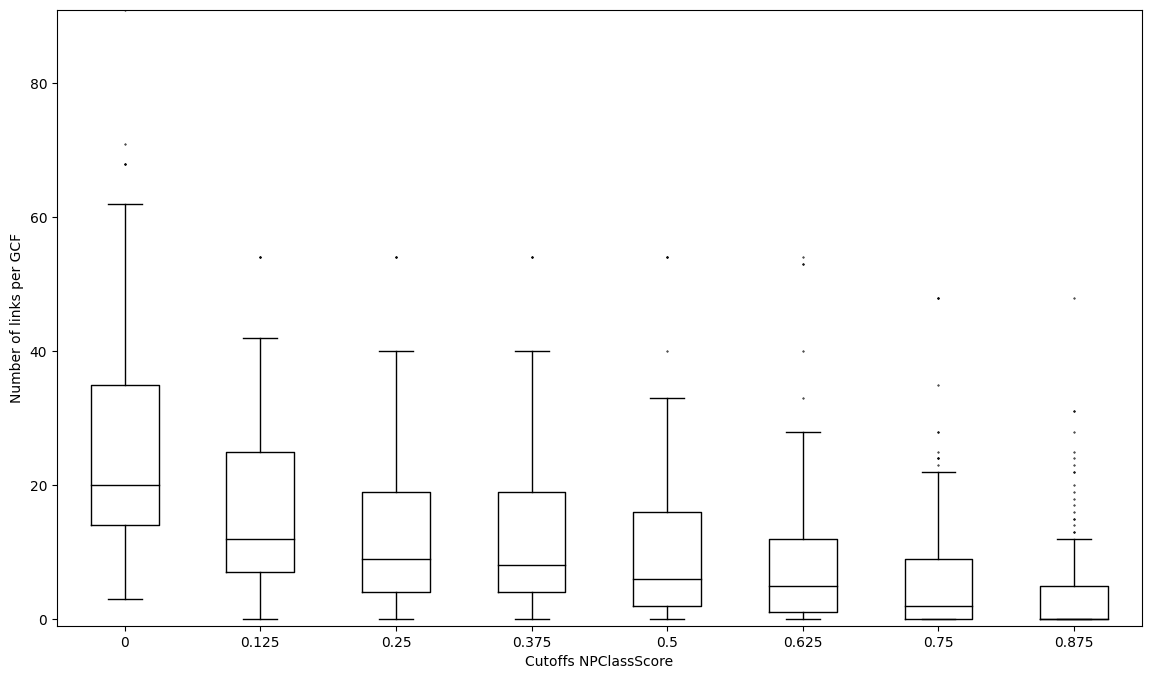

In [16]:
sorted_filt_items = sorted(d_all_num_filtered_links.items())
labels = ["0"] + [f"{cut}" for cut, vals in sorted_filt_items]
xs = [d_all_num_links] + [vals for keys, vals in sorted_filt_items]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
links_title = "Number of links per GCF"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.boxplot(xs, labels=labels, flierprops={"markersize": 0.5}, medianprops={"color": "black"})
plt.setp(ax, ylim=custom_xlim, xlabel="Cutoffs NPClassScore", ylabel=links_title)
figout = "boxplot_cutoffs_MSV000084950_npclass_mix_can-mne_figure.svg"
plt.savefig(figout)

Use MNE when there is no CANOPUS prediction
Bin size: 5


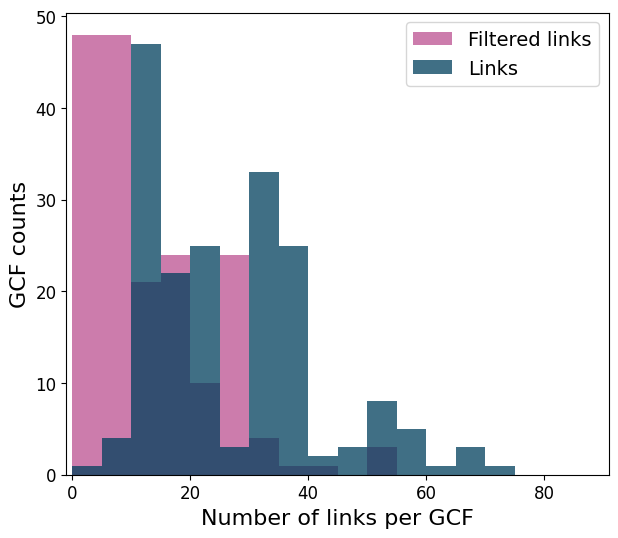

In [18]:
print("Use MNE when there is no CANOPUS prediction")
labels = ["Links", "Filtered links"]
colours = ["#003f5c", "#bc5090", "#ffa600"]
xs = [all_num_links, all_num_filtered_links]
lg_size = 14
custom_xlim = (-1, max(d_all_num_links))
bin_size = 5
print("Bin size:", bin_size)
n_bins = np.arange(0, max(d_all_num_links), bin_size)
links_title = "Number of links per GCF"
count_title = "GCF counts"
hist_type = "stepfilled"
alpha = 0.75

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
ax0.hist(xs[:2], bins=n_bins, density=False, histtype=hist_type, stacked=False, label=labels[:2],
         color=colours[:2], alpha=alpha)
ax0.legend(prop={'size': lg_size})
plt.setp(ax0, xlim=custom_xlim, xlabel=links_title, ylabel=count_title)
figout = "filtered_links_MSV000084950_mix_can-mne_figure_new.svg"
plt.savefig(figout)

In [241]:
# save xs
xs_out = 'filtered_data_MSV000084950.pickle'
pickle.dump(xs, open(xs_out, 'wb'))

## Investigate known links

In [34]:
known_links_dict = {}

### Anabaenopeptins 

In [122]:
# cblaster results of BGC0000302 yields best hits to NC_019427.1.region004 and NZ_CP043056.1.region006
# gcf id 28 has both of these
name_hit = 'anabaenopeptin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [2429, 2412, 2512, 2545, 2513]  # spectra from MF 54 as listed on PoDP MSV000084950

bgcs_names = ['NZ_AP018314.1.region007', 'NZ_CP043056.1.region006', 'NC_019427.1.region004']
result_bgcs = [bgc for bgc in npl.bgcs if bgc.name in bgcs_names]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=15, name=NZ_AP018314.1.region007, strain=Strain(Sphaerospermopsis kisseleviana NIES-73) [4 aliases], asid=NZ_AP018314.1, region=7), BGC(id=42, name=NZ_CP043056.1.region006, strain=Strain(Dolichospermum sp. UHCC 0315A) [4 aliases], asid=NZ_CP043056.1, region=6), BGC(id=68, name=NC_019427.1.region004, strain=Strain(Dolichospermum sp. UHCC 0090) [5 aliases], asid=NC_019427.1, region=4)]
{GCF(id=12, class=Others, gcf_id=59, strains=1), GCF(id=28, class=Others, gcf_id=153, strains=6), GCF(id=38, class=Others, gcf_id=211, strains=4), GCF(id=68, class=Others, gcf_id=32, strains=1)} 4


In [126]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 28][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=28, class=Others, gcf_id=153, strains=6),
 StrainCollection(n=6) [Dolichospermum sp. UHCC 0315A,Dolichospermum sp. UHCC 0299,Dolichospermum sp. UHCC 0352,Dolichospermum sp. UHCC 0260,Dolichospermum sp. UHCC 0406,Dolichospermum sp. UHCC 0090],
 {BGC(id=42, name=NZ_CP043056.1.region006, strain=Strain(Dolichospermum sp. UHCC 0315A) [4 aliases], asid=NZ_CP043056.1, region=6),
  BGC(id=43, name=NZ_VIKV01000211.region001, strain=Strain(Dolichospermum sp. UHCC 0299) [15 aliases], asid=NZ_VIKV01000211, region=1),
  BGC(id=44, name=NZ_VIKY01000297.region001, strain=Strain(Dolichospermum sp. UHCC 0352) [15 aliases], asid=NZ_VIKY01000297, region=1),
  BGC(id=45, name=NZ_VIKZ01000011.region001, strain=Strain(Dolichospermum sp. UHCC 0260) [16 aliases], asid=NZ_VIKZ01000011, region=1),
  BGC(id=46, name=NZ_VILA01000007.region001, strain=Strain(Dolichospermum sp. UHCC 0406) [14 aliases], asid=NZ_VILA01000007, region=1),
  BGC(id=68, name=NC_019427.1.region004, strain=Strain(Dolichospermum sp.

In [127]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 25
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=28, class=Others, gcf_id=153, strains=6), 28 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=140, spectrum_id=1028, strains=6)	metcalf=4.6904	shared strains=6	MF=50
NPClassScore: (0.9285714285714286, 'as_classes', 'npc_pathway', 'betalactone', 'Amino acids and Peptides')
Precursor_mz: 419.20401
2.(3)	Spectrum(id=123, spectrum_id=990, strains=5)	metcalf=4.1611	shared strains=5	MF=-1
NPClassScore: (0.9285714285714286, 'as_classes', 'npc_pathway', 'betalactone', 'Amino acids and Peptides')
Precursor_mz: 405.20099
2.(3)	Spectrum(id=558, spectrum_id=2499, strains=5)	metcalf=4.1611	shared strains=5	MF=50
NPClassScore: (0.9285714285714286, 'as_classes', 'npc_pathway', 'betalactone', 'Amino acids and Peptides')
Precursor_mz: 837.521
2.(3)	Spectrum(id=562, spectrum_id=2513, strains=5)	metcalf=4.1611	shared strains=5	MF=54
NPClassScore: (0.9285714285714286, 'as_classes', 'npc_pathway', 'betalactone', 'Amino acids and Peptides')
Precursor

In [125]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

33 21


### Micropeptins 

In [215]:
# cblaster results of BGC0000332 yields hit NZ_JXYX01000001.region002 from Microcystis aeruginosa NIES-88 as indicated on PoDP
name_hit = 'micropeptin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [spec.spectrum_id for spec in
                 [mf for mf in npl.molfams if mf.family_id == 26][0].spectra
                ]  # spectra from MF 26 as listed on PoDP MSV000084950

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_JXYX01000001.region002"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=19, name=NZ_JXYX01000001.region002, strain=Strain(Microcystis aeruginosa NIES-88) [12 aliases], asid=NZ_JXYX01000001, region=2)]
{GCF(id=13, class=Others, gcf_id=68, strains=4)} 1


In [216]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 13][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=13, class=Others, gcf_id=68, strains=4),
 StrainCollection(n=4) [Microcystis aeruginosa NIES-843,Microcystis viridis NIES-102,Microcystis aeruginosa NIES-298,Microcystis aeruginosa NIES-88],
 {BGC(id=16, name=NC_010296.1.region012, strain=Strain(Microcystis aeruginosa NIES-843) [4 aliases], asid=NC_010296.1, region=12),
  BGC(id=17, name=NZ_AP019314.1.region007, strain=Strain(Microcystis viridis NIES-102) [4 aliases], asid=NZ_AP019314.1, region=7),
  BGC(id=18, name=NZ_CP046058.1.region013, strain=Strain(Microcystis aeruginosa NIES-298) [4 aliases], asid=NZ_CP046058.1, region=13),
  BGC(id=19, name=NZ_JXYX01000001.region002, strain=Strain(Microcystis aeruginosa NIES-88) [12 aliases], asid=NZ_JXYX01000001, region=2)})

In [217]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 50
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=13, class=Others, gcf_id=68, strains=4), 37 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=201, spectrum_id=1266, strains=4)	metcalf=4.6904	shared strains=4	MF=-1
NPClassScore: (0.75, 'as_classes', 'npc_pathway', 'microviridin', 'Amino acids and Peptides')
Precursor_mz: 476.345
2.(6)	Spectrum(id=552, spectrum_id=2493, strains=5)	metcalf=4.0833	shared strains=4	MF=1
NPClassScore: (0.3718861209964413, 'as_classes', 'cf_subclass', 'NRPS', 'Amino acids, peptides, and analogues')
Precursor_mz: 834.599
3.(9)	Spectrum(id=457, spectrum_id=2204, strains=3)	metcalf=3.9592	shared strains=3	MF=47
NPClassScore: (1.0, 'as_classes', 'npc_superclass', 'microviridin', 'Oligopeptides')
Precursor_mz: 675.284
3.(9)	Spectrum(id=458, spectrum_id=2205, strains=3)	metcalf=3.9592	shared strains=3	MF=47
NPClassScore: (0.75, 'as_classes', 'npc_pathway', 'microviridin', 'Amino acids and Peptides')
Precursor_mz: 675.284
3.(9)	Spectrum(id=557, spectrum_id=

In [218]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

50 31


In [219]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])

--- ObjectLink(source=GCF(id=13, class=Others, gcf_id=68, strains=4), target=Spectrum(id=539, spectrum_id=2432, strains=1), #methods=1)
[(1.0, 'as_classes', 'npc_superclass', 'microviridin', 'Oligopeptides')]
--- ObjectLink(source=GCF(id=13, class=Others, gcf_id=68, strains=4), target=Spectrum(id=565, spectrum_id=2520, strains=1), #methods=1)
[(1.0, 'as_classes', 'npc_superclass', 'microviridin', 'Oligopeptides')]
--- ObjectLink(source=GCF(id=13, class=Others, gcf_id=68, strains=4), target=Spectrum(id=578, spectrum_id=2550, strains=1), #methods=1)
[(0.6666666666666666, 'as_classes', 'cf_superclass', 'microviridin', 'Organic acids and derivatives')]
--- ObjectLink(source=GCF(id=13, class=Others, gcf_id=68, strains=4), target=Spectrum(id=669, spectrum_id=2763, strains=1), #methods=1)
[(0.6666666666666666, 'as_classes', 'cf_superclass', 'microviridin', 'Organic acids and derivatives')]
--- ObjectLink(source=GCF(id=13, class=Others, gcf_id=68, strains=4), target=Spectrum(id=674, spectrum_i

In [223]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Kawaguchipeptin B

In [97]:
# knownclusterblast found NZ_JXYX01000010.region001 as BGC0001632 in Microcystis aeruginosa NIES-88 as indicated in MIBiG
name_hit = 'kawaguchipeptin'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [2858]  # as listed on PoDP MSV000084950

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_JXYX01000010.region001"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=186, name=NZ_JXYX01000010.region001, strain=Strain(Microcystis aeruginosa NIES-88) [12 aliases], asid=NZ_JXYX01000010, region=1)]
{GCF(id=125, class=RiPPs, gcf_id=129, strains=1)} 1


In [98]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 125][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=125, class=RiPPs, gcf_id=129, strains=1),
 StrainCollection(n=1) [Microcystis aeruginosa NIES-88],
 {BGC(id=186, name=NZ_JXYX01000010.region001, strain=Strain(Microcystis aeruginosa NIES-88) [12 aliases], asid=NZ_JXYX01000010, region=1)})

In [99]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 50
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=125, class=RiPPs, gcf_id=129, strains=1), 57 total links, 1 methods used
Rank above cutoff (original rank)
1.(2)	Spectrum(id=194, spectrum_id=1239, strains=1)	metcalf=4.6904	shared strains=1	MF=-1
NPClassScore: (0.9, 'as_classes', 'cf_subclass', 'cyanobactin', 'Amino acids, peptides, and analogues')
Precursor_mz: 461.776
1.(2)	Spectrum(id=200, spectrum_id=1261, strains=1)	metcalf=4.6904	shared strains=1	MF=-1
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 473.30099
1.(2)	Spectrum(id=246, spectrum_id=1473, strains=1)	metcalf=4.6904	shared strains=1	MF=37
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 523.27399
1.(2)	Spectrum(id=251, spectrum_id=1498, strains=1)	metcalf=4.6904	shared strains=1	MF=-1
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 529.85498
1.(2)	Spectrum(id=266, spectrum_

In [102]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

68 54


### Microcyclamide

In [104]:
# knownclusterblast found NZ_CP046058.1.region009 as BGC0000473 in Microcystis aeruginosa NIES-298 as indicated in MIBiG
name_hit = 'microcyclamide'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [1809]  # as listed on PoDP MSV000084950

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NZ_CP046058.1.region009"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=182, name=NZ_CP046058.1.region009, strain=Strain(Microcystis aeruginosa NIES-298) [4 aliases], asid=NZ_CP046058.1, region=9)]
{GCF(id=120, class=RiPPs, gcf_id=117, strains=1)} 1


In [105]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 120][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=120, class=RiPPs, gcf_id=117, strains=1),
 StrainCollection(n=1) [Microcystis aeruginosa NIES-298],
 {BGC(id=182, name=NZ_CP046058.1.region009, strain=Strain(Microcystis aeruginosa NIES-298) [4 aliases], asid=NZ_CP046058.1, region=9)})

In [106]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 50
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=120, class=RiPPs, gcf_id=117, strains=1), 31 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=210, spectrum_id=1293, strains=1)	metcalf=4.6904	shared strains=1	MF=-1
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 487.104
1.(1)	Spectrum(id=211, spectrum_id=1294, strains=1)	metcalf=4.6904	shared strains=1	MF=3
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 487.104
1.(1)	Spectrum(id=265, spectrum_id=1611, strains=1)	metcalf=4.6904	shared strains=1	MF=3
NPClassScore: (0.9, 'as_classes', 'cf_subclass', 'cyanobactin', 'Amino acids, peptides, and analogues')
Precursor_mz: 541.12903
1.(1)	Spectrum(id=343, spectrum_id=1809, strains=1)	metcalf=4.6904	shared strains=1	MF=73
NPClassScore: (1.0, 'as_classes', 'npc_pathway', 'cyanobactin', 'Amino acids and Peptides')
Precursor_mz: 583.19501
--MATCH--
1.(1)	Spectrum(id=344, spe

In [107]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

35 23


### Microcystins

In [224]:
# cblaster results of BGC0001016 yields as best hit NC_019427.1.region004
name_hit = 'microcystins'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [spec.spectrum_id for spec in
                 [mf for mf in npl.molfams if mf.family_id == 23][0].spectra
                ]  # spectra from MF 26 as listed on PoDP MSV000084950

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_019427.1.region004"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=68, name=NC_019427.1.region004, strain=Strain(Dolichospermum sp. UHCC 0090) [5 aliases], asid=NC_019427.1, region=4)]
{GCF(id=28, class=Others, gcf_id=153, strains=6), GCF(id=38, class=Others, gcf_id=211, strains=4), GCF(id=68, class=Others, gcf_id=32, strains=1)} 3


In [225]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 38][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=38, class=Others, gcf_id=211, strains=4),
 StrainCollection(n=4) [Dolichospermum sp. UHCC 0090,Dolichospermum sp. UHCC 0315A,Dolichospermum sp. UHCC 0352,Dolichospermum sp. UHCC 0260],
 {BGC(id=68, name=NC_019427.1.region004, strain=Strain(Dolichospermum sp. UHCC 0090) [5 aliases], asid=NC_019427.1, region=4),
  BGC(id=69, name=NZ_CP043056.1.region011, strain=Strain(Dolichospermum sp. UHCC 0315A) [4 aliases], asid=NZ_CP043056.1, region=11),
  BGC(id=70, name=NZ_VIKY01000283.region001, strain=Strain(Dolichospermum sp. UHCC 0352) [15 aliases], asid=NZ_VIKY01000283, region=1),
  BGC(id=71, name=NZ_VIKZ01000014.region001, strain=Strain(Dolichospermum sp. UHCC 0260) [16 aliases], asid=NZ_VIKZ01000014, region=1)})

In [226]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 50
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=38, class=Others, gcf_id=211, strains=4), 21 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=140, spectrum_id=1028, strains=6)	metcalf=3.6225	shared strains=4	MF=50
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 419.20401
2.(2)	Spectrum(id=152, spectrum_id=1049, strains=4)	metcalf=3.2709	shared strains=3	MF=50
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 426.21301
2.(2)	Spectrum(id=153, spectrum_id=1050, strains=4)	metcalf=3.2709	shared strains=3	MF=50
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 426.21301
2.(2)	Spectrum(id=563, spectrum_id=2518, strains=4)	metcalf=3.2709	shared strains=3	MF=34
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 847.53101
2.(2)	Spectrum(id=564

In [227]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

27 19


### Microcystin RR

In [228]:
# should be present in Microcystis aeruginosa NIES-843 according to PoDP - cblaster hits BGC0001017 to NC_010296.1.region009
name_hit = 'microcystin-rr'
known_links_dict[name_hit] = {'hits': [], 'counts': None}
spectrum_hits = [2758]  # as listed on PoDP MSV000084950

result_bgcs = [bgc for bgc in npl.bgcs if bgc.name == "NC_010296.1.region009"]
print(result_bgcs)
result_gcfs = set([parent for bgc in result_bgcs for parent in bgc.parents])
print(result_gcfs, len(result_gcfs))

[BGC(id=30, name=NC_010296.1.region009, strain=Strain(Microcystis aeruginosa NIES-843) [4 aliases], asid=NC_010296.1, region=9)]
{GCF(id=23, class=PKS-NRP_Hybrids, gcf_id=124, strains=4)} 1


In [229]:
# the spectrum as listed on PoDP does have predicted classes from mne
spec = [spec for spec in npl.spectra if spec.spectrum_id in spectrum_hits][0]
spec_id = str(spec.spectrum_id)
spec, spec.strains, npl.chem_classes.canopus.spectra_classes.get(spec_id), npl.chem_classes.molnetenhancer.spectra_classes(spec_id)

(Spectrum(id=667, spectrum_id=2758, strains=3),
 StrainCollection(n=3) [Microcystis viridis NIES-102,Microcystis aeruginosa NIES-88,Dolichospermum sp. UHCC 0352],
 None,
 [('Organic compounds', 1.0),
  ('Organic acids and derivatives', 1.0),
  ('Carboxylic acids and derivatives', 1.0),
  ('Amino acids, peptides, and analogues', 1.0),
  ('Oligopeptides', 1.0),
  ('Aromatic heteropolycyclic compounds', 1.0)])

In [231]:
result_gcf = [gcf for gcf in npl.gcfs if gcf.id == 23][0]
result_gcf, result_gcf.strains, result_gcf.bgcs

(GCF(id=23, class=PKS-NRP_Hybrids, gcf_id=124, strains=4),
 StrainCollection(n=4) [Microcystis aeruginosa NIES-843,Microcystis viridis NIES-102,Microcystis aeruginosa NIES-298,Microcystis aeruginosa NIES-88],
 {BGC(id=30, name=NC_010296.1.region009, strain=Strain(Microcystis aeruginosa NIES-843) [4 aliases], asid=NC_010296.1, region=9),
  BGC(id=31, name=NZ_AP019314.1.region004, strain=Strain(Microcystis viridis NIES-102) [4 aliases], asid=NZ_AP019314.1, region=4),
  BGC(id=32, name=NZ_CP046058.1.region006, strain=Strain(Microcystis aeruginosa NIES-298) [4 aliases], asid=NZ_CP046058.1, region=6),
  BGC(id=33, name=NZ_JXYX01000004.region001, strain=Strain(Microcystis aeruginosa NIES-88) [12 aliases], asid=NZ_JXYX01000004, region=1)})

In [232]:
cutoff = 0.25
result_links_both = results_both.links[result_gcf]
result_links_mc = results.get_sorted_links(mc, result_gcf)
count = 0
i = 0
show_x = 50
include_below_cutoff = False
prev_mc = 10**100
i_delay = 0
delay = 0 
print('Results for object: {}, {} total links, {} methods used'.format(result_gcf, len(result_links_both), results.method_count))
print("Rank above cutoff (original rank)")
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        link_data_both = result_links_both.get(link_data.target)
        cur_mc = link_data[mc]
        if cur_mc < prev_mc:
            i += 1
            i += i_delay
            i_delay = 0
        else:
            i_delay += 1
        
        pref = 'x.'
        cl_score = None
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    if cur_mc < prev_mc:
                        count += 1
                        count += delay
                        delay = 0
                    else:
                        delay += 1
                    pref = f"{count}."
                    prev_mc = cur_mc
        if include_below_cutoff or not pref == 'x.':
            print('{}({})\t{}\t{}={}\tshared strains={}\tMF={}'.format(
                pref,
                i,
                link_data.target,
                ','.join(method.name for method in link_data.methods),
                mc.format_data(cur_mc),
                len(link_data.shared_strains),
                link_data.target.family_id))
            if cl_score:
                print('NPClassScore:', cl_score[0])
            comp_name = ''
            if link_data.target.gnps_annotations:
                comp_name = link_data.target.gnps_annotations.get("Compound_Name")
                print('Library match:', comp_name)
            print('Precursor_mz:', link_data.target.precursor_mz)
            if link_data.target.spectrum_id in spectrum_hits or name_hit in comp_name.lower():
                print("--MATCH--")
                known_links_dict[name_hit]['hits'].append((count, i, result_gcf, link_data))
    if count + delay == show_x:
        break

Results for object: GCF(id=23, class=PKS-NRP_Hybrids, gcf_id=124, strains=4), 32 total links, 1 methods used
Rank above cutoff (original rank)
1.(1)	Spectrum(id=201, spectrum_id=1266, strains=4)	metcalf=4.6904	shared strains=4	MF=-1
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 476.345
2.(6)	Spectrum(id=552, spectrum_id=2493, strains=5)	metcalf=4.0833	shared strains=4	MF=1
NPClassScore: (0.3718861209964413, 'as_classes', 'cf_subclass', 'NRPS', 'Amino acids, peptides, and analogues')
Precursor_mz: 834.599
3.(9)	Spectrum(id=457, spectrum_id=2204, strains=3)	metcalf=3.9592	shared strains=3	MF=47
NPClassScore: (0.5899705014749262, 'as_classes', 'npc_superclass', 'NRPS', 'Oligopeptides')
Precursor_mz: 675.284
3.(9)	Spectrum(id=458, spectrum_id=2205, strains=3)	metcalf=3.9592	shared strains=3	MF=47
NPClassScore: (0.532563025210084, 'as_classes', 'npc_pathway', 'NRPS', 'Amino acids and Peptides')
Precursor_mz: 675.284
3.(9)	Sp

In [233]:
filtered_counts = 0
metcalf_counts = 0
for link_data in result_links_mc:
    if isinstance(link_data.target, Spectrum):
        metcalf_counts += 1
        link_data_both = result_links_both.get(link_data.target)
        if link_data_both:
            cl_score = link_data_both[npcl]
            if cl_score:
                if cl_score[0][0] > cutoff:
                    filtered_counts += 1
                else:
                    if count_nones:
                        filtered_counts += 1

known_links_dict[name_hit]['counts'] = (metcalf_counts, filtered_counts)
print(metcalf_counts, filtered_counts)

50 27


In [234]:
# check if missing link does have npcl score
result_links_npcl = results_npcl.get_sorted_links(npcl_only, result_gcf)
for link_data in result_links_npcl:
    if isinstance(link_data.target, Spectrum):
#         print(link_data.target.spectrum_id)
        if link_data.target.spectrum_id in spectrum_hits:
            print('---',link_data)
            print(link_data[npcl_only])

--- ObjectLink(source=GCF(id=23, class=PKS-NRP_Hybrids, gcf_id=124, strains=4), target=Spectrum(id=667, spectrum_id=2758, strains=3), #methods=1)
[(0.6419354838709678, 'as_classes', 'cf_superclass', 'NRPS', 'Organic acids and derivatives')]


In [236]:
# does get found by NPClassScore above threshold but not by metcalf
known_links_dict[name_hit]['not_found'] = 'not in metcalf'

### Summarise

In [237]:
for k,v in known_links_dict.items():
    print(k,v)
    print()

anabaenopeptin {'hits': [(2, 3, GCF(id=28, class=Others, gcf_id=153, strains=6), ObjectLink(source=GCF(id=28, class=Others, gcf_id=153, strains=6), target=Spectrum(id=562, spectrum_id=2513, strains=5), #methods=1)), (5, 9, GCF(id=28, class=Others, gcf_id=153, strains=6), ObjectLink(source=GCF(id=28, class=Others, gcf_id=153, strains=6), target=Spectrum(id=538, spectrum_id=2429, strains=4), #methods=1)), (16, 28, GCF(id=28, class=Others, gcf_id=153, strains=6), ObjectLink(source=GCF(id=28, class=Others, gcf_id=153, strains=6), target=Spectrum(id=561, spectrum_id=2512, strains=3), #methods=1))], 'counts': (33, 21)}

micropeptin {'hits': [], 'counts': (50, 31), 'not_found': 'not in metcalf'}

kawaguchipeptin {'hits': [(1, 2, GCF(id=125, class=RiPPs, gcf_id=129, strains=1), ObjectLink(source=GCF(id=125, class=RiPPs, gcf_id=129, strains=1), target=Spectrum(id=722, spectrum_id=2858, strains=1), #methods=1))], 'counts': (68, 54)}

microcyclamide {'hits': [(1, 1, GCF(id=120, class=RiPPs, gcf_i

In [239]:
pickle_known_links_dict = {}
for k,v in known_links_dict.items():
    new_known_links = {}
    hit_list = v['hits']
    new_hit_list = [([hit[0], hit[1]]) for hit in hit_list]
    new_known_links['hits'] = new_hit_list
    new_known_links['counts'] = v['counts']
    if v.get('not_found'):
        new_known_links['not_found'] = v['not_found']
    pickle_known_links_dict[k] = new_known_links
pickle_known_links_dict

{'anabaenopeptin': {'hits': [[2, 3], [5, 9], [16, 28]], 'counts': (33, 21)},
 'micropeptin': {'hits': [],
  'counts': (50, 31),
  'not_found': 'not in metcalf'},
 'kawaguchipeptin': {'hits': [[1, 2]], 'counts': (68, 54)},
 'microcyclamide': {'hits': [[1, 1]], 'counts': (35, 23)},
 'microcystins': {'hits': [[11, 13], [15, 21]], 'counts': (27, 19)},
 'microcystin-rr': {'hits': [],
  'counts': (50, 27),
  'not_found': 'not in metcalf'}}

In [240]:
known_links_out = '/home/louwe015/NPLinker/known_links_dict_MSV000084950.pickle'
pickle.dump(pickle_known_links_dict, open(known_links_out, 'wb'))